# Data preprocessing

In [1]:
# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

## (a) Prepare a pandas data frame

In [2]:
# Read data from csv file
df = pd.read_csv('Uefa Euro Cup All Matches.csv')
# Our csv file is a little faulty because some cells contain 
# leading and trailing white spaces, so we remove all the bad spaces.
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

This is what our raw data looks like:

In [3]:
df

,Date,Time,HomeTeamName,AwayTeamName,HomeTeamGoals,AwayTeamGoals,Stage,SpecialWinConditions,Stadium,City,Attendance,Year
0,6 July 1960 (1960-07-06),20:00,France,Yugoslavia,4,5,Semi-finals,NaN,Parc des Princes,Paris,26370,1960
1,6 July 1960 (1960-07-06),21:30,Czechoslovakia,Soviet Union,0,3,Semi-finals,NaN,Stade Vélodrome,Marseille,25184,1960
2,9 July 1960 (1960-07-09),21:30,Czechoslovakia,France,2,0,Third place play-off,NaN,Stade Vélodrome,Marseille,9438,1960
3,10 July 1960 (1960-07-10),21:30,Soviet Union,Yugoslavia,2,1,Final,Soviet Union win after extra time,Parc des Princes,Paris,17966,1960
4,17 June 1964 (1964-06-17),20:00,Spain,Hungary,2,1,Semi-finals,Spain win after extra time,Santiago Bernabéu,Madrid,34713,1964
...,...,...,...,...,...,...,...,...,...,...,...,...
281,2 July 2016 (2016-07-02),21:00,Germany,Italy,1,1,Quarter-finals,Germany win on Penalities 6–5,Nouveau Stade de Bordeaux,Bordeaux,38764,2016
282,3 July 2016 (2016-07-03),21:00,France,Iceland,5,2,Quarter-finals,NaN,Stade de France,Saint-Denis,76833,2016
283,6 July 2016 (2016-07-06),21:00,Portugal,Wales,2,0,Semi-finals,NaN,Parc Olympique Lyonnais,Décines-Charpieu,55679,2016
284,7 July 2016 (2016-07-07),21:00,Germany,France,0,2,Semi-finals,NaN,Stade Vélodrome,Marseille,64078,2016


## (b) and (c) Removing missing values and discretize data

We remove some columns, which contain either NaN values or irrelevant data to our model:

In [4]:
df = df.drop(['Date', 'Time', 'SpecialWinConditions', 
              'Attendance', 'Stadium'], axis=1)
df

,HomeTeamName,AwayTeamName,HomeTeamGoals,AwayTeamGoals,Stage,City,Year
0,France,Yugoslavia,4,5,Semi-finals,Paris,1960
1,Czechoslovakia,Soviet Union,0,3,Semi-finals,Marseille,1960
2,Czechoslovakia,France,2,0,Third place play-off,Marseille,1960
3,Soviet Union,Yugoslavia,2,1,Final,Paris,1960
4,Spain,Hungary,2,1,Semi-finals,Madrid,1964
...,...,...,...,...,...,...,...
281,Germany,Italy,1,1,Quarter-finals,Bordeaux,2016
282,France,Iceland,5,2,Quarter-finals,Saint-Denis,2016
283,Portugal,Wales,2,0,Semi-finals,Décines-Charpieu,2016
284,Germany,France,0,2,Semi-finals,Marseille,2016


Because our model is discrete, we need to discretize the data frame.

First, we are going to add a new column called "Result", which indicates the result of Home Team against Away Team.

In [5]:
conditions_result = [
    df['HomeTeamGoals'] > df['AwayTeamGoals'],
    df['HomeTeamGoals'] == df['AwayTeamGoals'],
    df['HomeTeamGoals'] < df['AwayTeamGoals']
]
values_result = ['Won', 'Draw', 'Lost']
df['Result'] = np.select(conditions_result, values_result)
df[['HomeTeamGoals', 'AwayTeamGoals', 'Result']]

,HomeTeamGoals,AwayTeamGoals,Result
0,4,5,Lost
1,0,3,Lost
2,2,0,Won
3,2,1,Won
4,2,1,Won
...,...,...,...
281,1,1,Draw
282,5,2,Won
283,2,0,Won
284,0,2,Lost


Next, instead of using the number of goals of every single game, we calculate the average goals of all games precedented and split them into 3 range: Low, Mid and High.

However, we do not know how to divide them yet so let us calculate the average numbers of goals of every team and plot their probability distribution to have a better understanding.

In [6]:
# We group by both Team Name and Year. 
# Because it does not really make sense 
# to aggregate one Team Name in two different year.
average_goals_home = df.groupby(['HomeTeamName', 'Year']).aggregate(np.mean)
average_goals_away = df.groupby(['AwayTeamName', 'Year']).aggregate(np.mean)

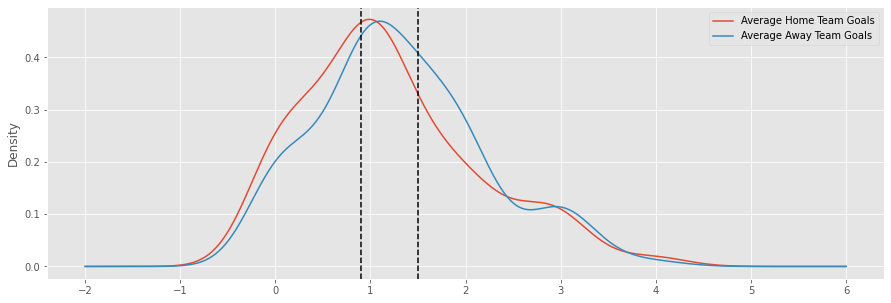

In [7]:
ax = average_goals_home['HomeTeamGoals'].plot.kde()
average_goals_away['HomeTeamGoals'].plot.kde(ax=ax)
ax.legend(['Average Home Team Goals', 'Average Away Team Goals'])
ax.axvline(0.9, 0, linestyle='dashed', color='Black')
ax.axvline(1.5, 0, linestyle='dashed', color='Black')

Based on the graph, we classify three intervals as following:

Low: less than 0.9

Mid: from 0.9 to 1.5

High: greater than or equal 1.5

Now we need to implement a function to do the job.

In [8]:
def get_average_goals(index, teamName, df, year):
    # select data for <teamName> and <year> only
    isTeamName_home = df['HomeTeamName'] == teamName
    isTeamName_away = df['AwayTeamName'] == teamName
    isYear = df['Year'] == year
    
    home = df[:index][isTeamName_home & isYear]['HomeTeamGoals']
    away = df[:index][isTeamName_away & isYear]['AwayTeamGoals']
    
    # calculate average goals
    both_home_away = pd.concat([home, away])
    av_decimal = np.mean(both_home_away)
    if av_decimal < 0.9:
        return 'Low'
    elif av_decimal < 1.5:
        return 'Mid'
    elif av_decimal >= 1.5:
        return 'High'
    else:
        return 'NoGamePlayed'

But what if a team had played no game before? The average goals cannot be calculated so we add another value called 'NoGamePlayed'.

We will loop through the whole data set to create two new columns.

In [9]:
numberOfRows = len(df.index)
HomeAverageGoals = []
AwayAverageGoals = []

for i in range(numberOfRows):
    row = df.loc[i]
    HomeAverageGoals.append(get_average_goals(i, row['HomeTeamName'], df, row['Year']))
    AwayAverageGoals.append(get_average_goals(i, row['AwayTeamName'], df, row['Year']))

C:\Users\hongh\AppData\Local\Temp/ipykernel_16780/453295669.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  home = df[:index][isTeamName_home & isYear]['HomeTeamGoals']
C:\Users\hongh\AppData\Local\Temp/ipykernel_16780/453295669.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  away = df[:index][isTeamName_away & isYear]['AwayTeamGoals']


Now adding two columns we just generated to the data frame

In [10]:
df['HomeAverageGoals'] = HomeAverageGoals
df['AwayAverageGoals'] = AwayAverageGoals
df

,HomeTeamName,AwayTeamName,HomeTeamGoals,AwayTeamGoals,Stage,City,Year,Result,HomeAverageGoals,AwayAverageGoals
0,France,Yugoslavia,4,5,Semi-finals,Paris,1960,Lost,NoGamePlayed,NoGamePlayed
1,Czechoslovakia,Soviet Union,0,3,Semi-finals,Marseille,1960,Lost,NoGamePlayed,NoGamePlayed
2,Czechoslovakia,France,2,0,Third place play-off,Marseille,1960,Won,Low,High
3,Soviet Union,Yugoslavia,2,1,Final,Paris,1960,Won,High,High
4,Spain,Hungary,2,1,Semi-finals,Madrid,1964,Won,NoGamePlayed,NoGamePlayed
...,...,...,...,...,...,...,...,...,...,...
281,Germany,Italy,1,1,Quarter-finals,Bordeaux,2016,Draw,High,Mid
282,France,Iceland,5,2,Quarter-finals,Saint-Denis,2016,Won,High,High
283,Portugal,Wales,2,0,Semi-finals,Décines-Charpieu,2016,Won,Mid,High
284,Germany,France,0,2,Semi-finals,Marseille,2016,Lost,Mid,High


We have no more thing to do with the numbers of goals so let's remove them.

In [11]:
df = df.drop(['HomeTeamGoals', 'AwayTeamGoals'], axis=1)

To provide even more data for our model, we want to add another two columns to called "Home5LastGames" and "Away5LastGames" whose values are determined as following:

'Good' if total of Won > total of Lost

'Neutral' if total of Won == total of Lost or there had been no game yet

'Bad' if total of Won < total of Lost

Now we will write a function to fill in the columns

In [12]:
def last5game(index, teamName, dataFrame, year):
    
    numberOfLastGames = 0
    won_lost_count = 0
    
    while numberOfLastGames != 5:
        if index == 0:
            break
        
        index -= 1 # go up to previous row
        row = dataFrame.loc[index]
        
        # Break if year is different 
        # Because we are going upward and 
        # the data frame is sorted by year.
        if  row['Year'] != year:
            break
        
        # teamName is in HomeTeamName
        if(row['HomeTeamName'] == teamName):
            if row['Result'] == 'Won':
                won_lost_count += 1
                numberOfLastGames += 1
            elif row['Result'] == 'Lost':
                won_lost_count -= 1
                numberOfLastGames +=1
            else:
                numberOfLastGames +=1
        
        # teamName is in AwayTeamName
        elif (row['AwayTeamName'] == teamName):
            if row['Result'] == 'Lost':
                won_lost_count += 1
                numberOfLastGames += 1
            elif row['Result'] == 'Won':
                won_lost_count -= 1
                numberOfLastGames +=1
            else:
                numberOfLastGames +=1
    
    if won_lost_count > 0:
        return 'Good'
    elif won_lost_count == 0:
        return 'Neutral'
    else:
        return 'Bad'

Doing the loop thing again.

In [13]:
Home5LastGames = []
Away5LastGames = []

for i in range(numberOfRows):
    row = df.loc[i]
    Home5LastGames.append(last5game(i, row['HomeTeamName'], df, row['Year']))
    Away5LastGames.append(last5game(i, row['AwayTeamName'], df, row['Year']))
df['Home5LastGames'] = Home5LastGames
df['Away5LastGames'] = Away5LastGames
df

,HomeTeamName,AwayTeamName,Stage,City,Year,Result,HomeAverageGoals,AwayAverageGoals,Home5LastGames,Away5LastGames
0,France,Yugoslavia,Semi-finals,Paris,1960,Lost,NoGamePlayed,NoGamePlayed,Neutral,Neutral
1,Czechoslovakia,Soviet Union,Semi-finals,Marseille,1960,Lost,NoGamePlayed,NoGamePlayed,Neutral,Neutral
2,Czechoslovakia,France,Third place play-off,Marseille,1960,Won,Low,High,Bad,Bad
3,Soviet Union,Yugoslavia,Final,Paris,1960,Won,High,High,Good,Good
4,Spain,Hungary,Semi-finals,Madrid,1964,Won,NoGamePlayed,NoGamePlayed,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...
281,Germany,Italy,Quarter-finals,Bordeaux,2016,Draw,High,Mid,Good,Good
282,France,Iceland,Quarter-finals,Saint-Denis,2016,Won,High,High,Good,Good
283,Portugal,Wales,Semi-finals,Décines-Charpieu,2016,Won,Mid,High,Good,Good
284,Germany,France,Semi-finals,Marseille,2016,Lost,Mid,High,Good,Good


Our data is almost complete. We just need to make some minor adjustments to optimize readability and consistency of data.

In [14]:
# rearrange columns
df = df[['HomeTeamName', 'AwayTeamName', 'Result',
         'HomeAverageGoals', 'AwayAverageGoals', 'Home5LastGames',
         'Away5LastGames', 'Stage', 'City', 'Year']]

Some values of the Stage column are 'Group 1' or 'Group 2' (before 1992) while some are 'Group A' or 'Group B' (after 1992).

In [15]:
print(df[['Stage', 'Year']][25:29])
print(df[['Stage', 'Year']][84:88])

      Stage  Year
25  Group 1  1980
26  Group 1  1980
27  Group 2  1980
28  Group 2  1980
      Stage  Year
84  Group A  1996
85  Group A  1996
86  Group B  1996
87  Group B  1996


Therefore, for the model to work better, we change all the numbers to letters.

In [16]:
df['Stage'] = df['Stage'].str.replace('1', 'A').str.replace('2', 'B')
print(df[['Stage', 'Year']][25:29])
print(df[['Stage', 'Year']][84:88])

      Stage  Year
25  Group A  1980
26  Group A  1980
27  Group B  1980
28  Group B  1980
      Stage  Year
84  Group A  1996
85  Group A  1996
86  Group B  1996
87  Group B  1996


This is what our data frame looks like now.

In [23]:
df[90:105]

,HomeTeamName,AwayTeamName,Result,HomeAverageGoals,AwayAverageGoals,Home5LastGames,Away5LastGames,Stage,City,Year
90,France,Bulgaria,Won,Mid,Mid,Good,Good,Group B,Newcastle,1996
91,Romania,Spain,Lost,Low,Mid,Bad,Neutral,Group B,Leeds,1996
92,Germany,Czech Republic,Won,NoGamePlayed,NoGamePlayed,Neutral,Neutral,Group C,Manchester,1996
93,Italy,Russia,Won,NoGamePlayed,NoGamePlayed,Neutral,Neutral,Group C,Liverpool,1996
94,Czech Republic,Italy,Won,Low,High,Bad,Good,Group C,Liverpool,1996
95,Russia,Germany,Lost,Mid,High,Bad,Good,Group C,Manchester,1996
96,Russia,Czech Republic,Draw,Low,Mid,Bad,Neutral,Group C,Liverpool,1996
97,Italy,Germany,Draw,High,High,Neutral,Good,Group C,Manchester,1996
98,Denmark,Portugal,Draw,NoGamePlayed,NoGamePlayed,Neutral,Neutral,Group D,Sheffield,1996
99,Turkey,Croatia,Lost,NoGamePlayed,NoGamePlayed,Neutral,Neutral,Group D,Nottingham,1996


We have completely processed and discretize our data.

The next steps will be modeling and predicting.

## (d) Save the dataframe

In [18]:
# saving the dataframe
df.to_csv('data_discretized.csv', index=False)